## Property24 Web Scrapper

This scrapper takes out the main information (*title, address, location, price, floor size, number of bathrooms, etc*) about rental offers on the [property24](https://www.property24.com/) website. It  works with  **offers for rent** and **sales**. It's essential to put correct link into scrapper (e.g. [link](https://www.property24.com/to-rent/advanced-search/results?sp=s%3d8682%2c8683%2c8677%2c10157%2c8017%2c9153%2c8112%2c8098%2c9117%2c8731%2c8686%2c8717%2c8754%2c8723%2c9119%2c8734%2c8736%2c8730%2c8806%2c8787)). 

Sometimes making a request to property24 requires a VPN or proxy connection (and country of VPN connection sometimes could have a huge impact on scrapper's speed).

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import time
import re

import cchardet
import lxml

from multiprocessing import Pool
import itertools as it

In [9]:
# paste the link to the first page of the request here

current_url = 'https://www.property24.com/for-sale/gauteng/1'
requests_session = requests.Session()


In [10]:
def get_soup_by_url(current_url):
    r = requests_session.get(current_url)
    soup = BeautifulSoup(r.text, 'lxml')
    
    
    headers = requests.utils.default_headers()
    headers.update({'User-Agent': 'My User Agent 1.0',})

    response = requests.get(current_url, headers=headers)
    return soup

Parsing of all urls could take a while. If the request to website don't work try to change IP or VPN and use `time.sleep` function. Don't turn it on for small amounts of data. 

In [11]:
def get_data(current_url):
    urls = [] # list with all urls of pages to scrap
    pages_list = [] # list with all scrapped pages
    pages_len = 0 # number of offers collected
    block = 10 # number to get fancy progress statement
    n_block = 2

    while True:  
        soup = get_soup_by_url(current_url)
        urls.append(current_url)

        pages = soup.find_all(class_="p24_content")
        pages_list.append(pages)
        pages_len += len(pages)

        pager = soup.find(class_="p24_pager").find(class_="pull-right")
        next_link = pager.get('href')
        
        # finding if it last page or not
        if 'javascript:;' in next_link:
            break
        current_url = next_link
        
        #time.sleep(random.randint(2,9))
        
        # fancy progress statement
        if (pages_len >= block):
            print(pages_len, "offers collected...")
            block *= n_block
        
        if block > 30000:
            n_block = 1.3

    print('Number of pages collected –', len(urls))
    print('Number of offers collected –', pages_len)
    
    return pages_list

In [12]:
#def get_pages(current_url):
    #pages = get_soup_by_url(current_url).find_all(class_="p24_content")
    # print(len(pages), 'pages on site')
    #return pages 

In [13]:
def get_features(all_pages):

    list_dicts = []
    list_features = ["p24_price", "p24_title", "p24_description", "p24_location", "p24_address", "p24_featureDetails", "p24_size"]

    for page_num in range(len(all_pages)):
        page_metadata = {}

        for feature in list_features:
            data = all_pages[page_num].find(class_= feature)

            if feature == "p24_price":
                if data.text.split()[-1] == 'm²':
                    try:
                        page_metadata['price_per_m'] = float(data['content'])
                    except:
                        try:
                            price = [str(s) for s in re.findall(r'-?\d+\.?\d*', data.text.strip())]
                            page_metadata['price_per_m'] = float(''.join(price))
                        except:
                            page_metadata['price_other'] = str(data.text.strip())
                        
                else: 
                    try:
                        page_metadata[data['itemprop']] = float(data['content'])
                    except:
                        try:
                            price = [str(s) for s in re.findall(r'-?\d+\.?\d*', data.text.strip())]
                            page_metadata['price'] = float(''.join(price))
                        except:
                            if str(data.text.strip()) == 'POA':
                                page_metadata['price_other'] = 'POA'
                                
            
            elif feature == "p24_title":
                try:
                    page_metadata[data['itemprop']] = data.text
                    
                except:
                    pass 
                
            elif feature == "p24_description":
                try:
                    page_metadata["name"] = data.text
                    
                except:
                    pass 
                    
            elif feature == "p24_location":
                try:
                    page_metadata['location'] = data.text
                except:
                    pass 

            elif feature == "p24_address":
                try:
                    page_metadata['address'] = data.text

                except:
                    pass

            elif feature == "p24_featureDetails":
                data = all_pages[page_num].find_all(class_="p24_featureDetails")

                for num in range(len(data)):
                    page_metadata[str(data[num]['title'])] = float((str(data[num].text)).strip())

            elif feature == "p24_size":

                try:
                    size = ((str(data.text)).strip()).split()
                    size_final = ''
                    for s in size:
                        if s.isdigit():
                            size_final += s
                            
                    page_metadata[str(data['title'])] = size_final

                except:
                    pass

        list_dicts.append(page_metadata)

    return list_dicts

### Gathering data and saving results

In [14]:
# scrapping data from website

pages_list = get_data(current_url)

23 offers collected...
46 offers collected...
69 offers collected...
92 offers collected...
161 offers collected...
340 offers collected...
648 offers collected...
1286 offers collected...
2562 offers collected...
5136 offers collected...
10240 offers collected...
20492 offers collected...
40974 offers collected...
53250 offers collected...
69244 offers collected...
89990 offers collected...
117006 offers collected...
Number of pages collected – 6367
Number of offers collected – 140078


In [15]:
# getting features from pages

result = []

for page in pages_list:
    result += get_features(page)

In [16]:
df = pd.DataFrame(result)
#df = df.reindex(
    #columns=['name', 'location', 'address', 'price', 'price_per_m',
            #'Floor Size','Gross Lettable Area', 'Erf Size','Bedrooms', 'Bathrooms', 'Parking Spaces'])
df

,price,name,location,address,Bedrooms,Bathrooms,Parking Spaces,Erf Size,Floor Size,price_other,Gross Lettable Area
0,5.275000e+06,3 Bedroom House in Franschhoek,Franschhoek,"17 Rue Montange Mystérieuse, Lion's Rest Priva...",3.0,2.5,4.0,400,NaN,NaN,NaN
1,2.599000e+06,Farm For Sale in Heatherdale AH,Heatherdale AH,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
2,5.500000e+07,Industrial Property in Ventershof AH,Ventershof AH,Plot 18b Hendrik Avenue,NaN,NaN,NaN,NaN,6000,NaN,NaN
3,1.225000e+06,2 Bedroom Townhouse in Equestria,Equestria,198 Furrow Road,2.0,2.0,1.0,NaN,NaN,NaN,NaN
4,2.450000e+06,3 Bedroom Apartment in Bryanston,Bryanston,Uzziel 59 Cumberland Avenue,3.0,2.0,2.0,NaN,101,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
140073,5.953500e+05,2 Bedroom Apartment,Karenpark,NaN,2.0,1.0,NaN,70,NaN,NaN,NaN
140074,9.800000e+05,Industrial Property,Duncanville,NaN,NaN,NaN,NaN,435,NaN,NaN,NaN
140075,4.900000e+05,Vacant Land,Three Rivers East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140076,4.150000e+06,4 Bedroom House,Parkmore,NaN,4.0,3.0,4.0,NaN,NaN,NaN,NaN


In [200]:
df.head(30)

,price_per_m,name,location,Gross Lettable Area,price,address,Bedrooms,Bathrooms,Parking Spaces,Floor Size,price_other,Erf Size
0,65.0,Industrial Property in Chloorkop,Chloorkop,27500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2 Bedroom Apartment in Carlswald,Carlswald,NaN,9.800000e+03,Cnr Walton & Surrey Rd,2.0,2.0,2.0,88,NaN,NaN
2,185.0,Commercial Property in Melrose Arch,Melrose Arch,247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,Commercial Property in Bruma,Bruma,1424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Industrial Property in New Doornfontein,New Doornfontein,22000,7.700000e+05,5 Beacon Street,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2 Bedroom Apartment in Barlow Park,Barlow Park,NaN,7.199000e+03,180 Katherine Street,2.0,1.0,1.0,50,NaN,NaN
6,NaN,1 Bedroom Apartment in Barlow Park,Barlow Park,NaN,5.899000e+03,180 Katherine Street,1.0,1.0,1.0,35,NaN,NaN
7,NaN,0.5 Bedroom Apartment in Barlow Park,Barlow Park,NaN,4.899000e+03,180 Katherine Street,0.5,1.0,1.0,26,NaN,NaN
8,NaN,3 Bedroom House in Kyalami Hills,Kyalami Hills,NaN,4.500000e+04,NaN,3.0,4.0,5.0,NaN,NaN,NaN
9,NaN,Commercial Property in Wynberg,Wynberg,NaN,NaN,81 5th Street,NaN,NaN,NaN,8000,POA\r\n per m²,NaN


## Cleaning

There are development projects with range price (e.g. 1500 - 1700). They is not real, so it's better to delete them. Next, we check whether we deleted these projects by checking is there any information in deleted cells. Typically, there is none.  

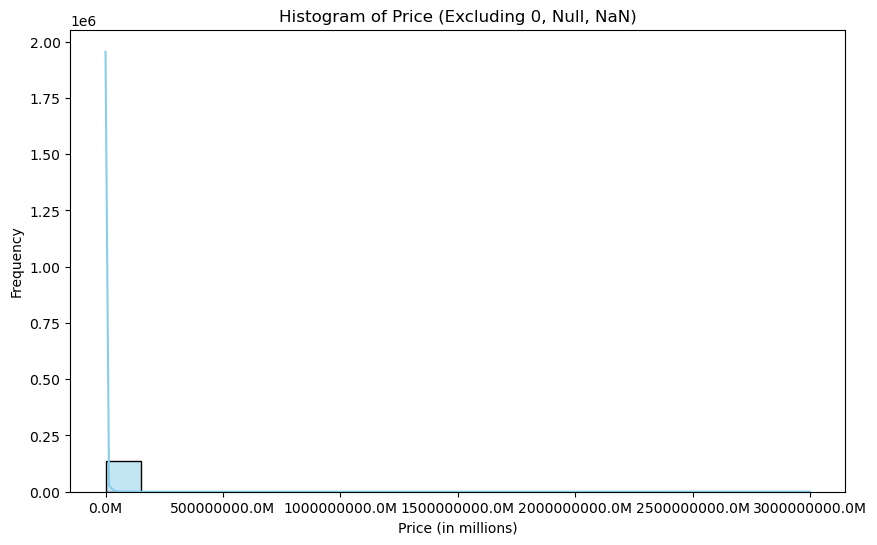

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Assuming you have a DataFrame named 'df' with a 'price' column

# Filter out rows with 0, null, or NaN in the 'price' column
filtered_df = df[df['price'].notnull() & (df['price'] != 0)]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Use Seaborn to create a fancy histogram with filtered data
ax = sns.histplot(data=filtered_df, x='price', kde=True, color='skyblue', bins=20)

# Customize the plot
plt.title('Histogram of Price (Excluding 0, Null, NaN)')
plt.ylabel('Frequency')

# Configure the x-axis to display values in millions
ax.set_xlabel('Price (in millions)')

# Define a custom formatting function for the x-axis labels
def millions(x, pos):
    'The two args are the value and tick position'
    return f'{x / 1e6:.1f}M'

# Apply the custom formatting function to the x-axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions))

# Show the plot
plt.show()


In [21]:
print("Shape of dataset before cleaning", df.shape)

df_false = df.loc[((df["price"]) > 275000275000.0)] #change the value
df_true = df.loc[((df["price"]) < 275000275000.0)] #change the value

print("Shape of dataset after cleaning", df_true.shape)

if df_false.iloc[:, 1:].isnull().values.any():
    print("False rows deleted")
else: 
    print("Something went wrong")

Shape of dataset before cleaning (140078, 11)
Shape of dataset after cleaning (132360, 11)
False rows deleted


In [22]:
# checking if there is any duplicated rows

df_true.duplicated().sum()

34563

In [23]:
# change path and file name to yours

df_true.to_csv("gauteng_sale.csv")

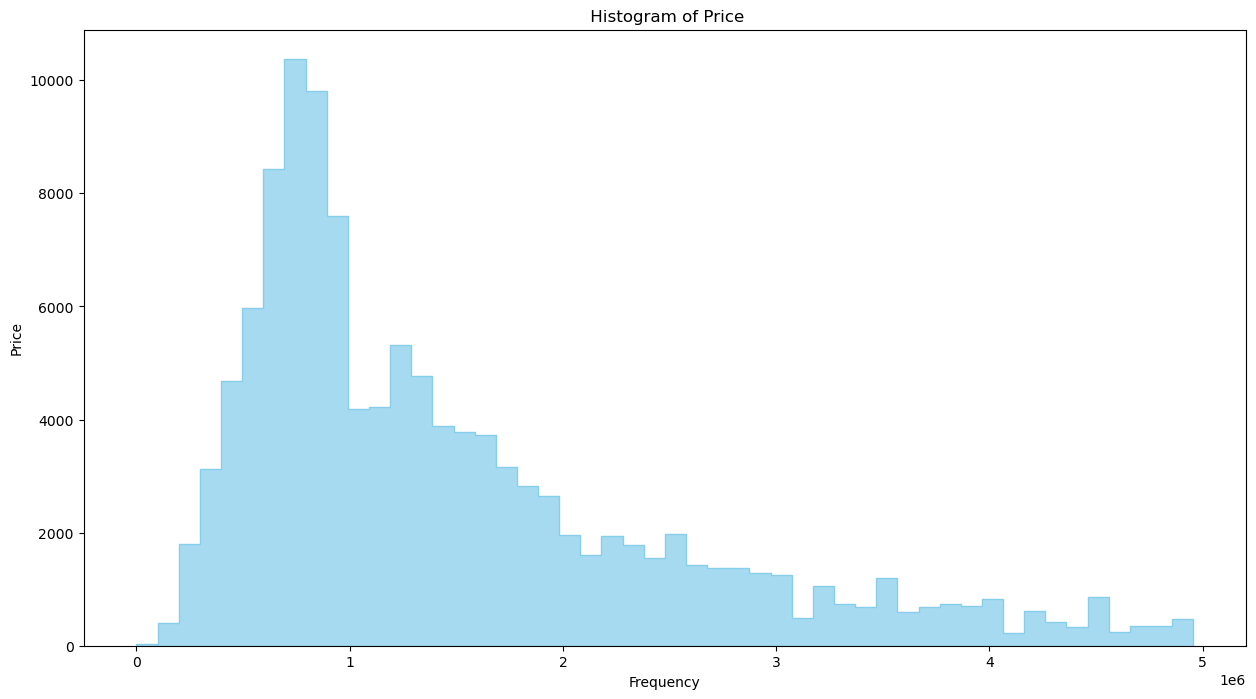

In [24]:

# Function to remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers from the 'price' column
filtered_df = remove_outliers_iqr(df_true, 'price')

# Create a figure and axis with a horizontal orientation
plt.figure(figsize=(15, 8))

# Use Seaborn to create a vertical fancy histogram with more bins
sns.histplot(data=filtered_df, x='price', color='skyblue', bins=50, element="step")

# Customize the plot
plt.title(' Histogram of Price')
plt.xlabel('Frequency')
plt.ylabel('Price')

# Show the plot
plt.show()
